# DTWKmeans Time series clustering

### Demo notebook for pynuTS 

Perform some experiments with pynuTS DTW based clustering

pynuTS by Nicola Procopio 2020

Original repository https://github.com/nickprock/pynuTS/

Forked by Marcello Morchio 2020

Forked repository https://github.com/mallibus/pynuTS

In [1]:
# allow import from parent directory
import sys,os
sys.path.append(os.getcwd() + '/..')

In [2]:
import pandas as pd
import numpy as np
from pynuTS.clustering import DTWKmeans

### Helper functions for simple TS visualization

In [3]:
import matplotlib.pyplot as plt

def plot_list_of_ts_over_subplots(list_of_series,figsize=(14,3)):
    """Plot a clustered list of timeseries, each cluster on a subplot with lines of same color.
    Cluster name is retrieved from the name of each series.
    
    Arguments:
    
    list_of_series : list of Pandas Series. the name of the series is the id of the cluster and shall be int
        
    figsize : tuple to set matplotlib figure size
    """
    df = pd.DataFrame(list_of_series)
    clusters = list(set(df.index))
    fig, axs = plt.subplots(len(clusters), sharex=True, sharey=True,figsize=figsize)
    for i,c in enumerate(clusters):
        df_cluster = df.loc[[c]]
        for _,l in df_cluster.iterrows():
            axs[i].plot(l,label=c,color=index_to_color(c))

def plot_list_of_ts(list_of_series,figsize=(14,3)):
    """Plot a clustered list of timeseries, each cluster with line of the same color
    Cluster name is retrieved from the name of each series.
    
    Arguments:
    
    list_of_series : list of Pandas Series. the name of the series is the id of the cluster and shall be int
        
    figsize : tuple to set matplotlib figure size
    """
    plt.figure(figsize=figsize)
    for l in list_of_series:
        plt.plot(l,label=l.name,color=index_to_color(l.name))

def index_to_color(i,cmap_name='tab10'):
    """Get a color from an integer.

    Arguments :
    
    i : int, to be converted to a color usable in matplotlib functions
    
    cmap_name : string to identify a matplotlib palette to pick colors from.
        see https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    cmap = plt.get_cmap(cmap_name)
    index = i % cmap.N
    return cmap.colors[index]

### Helper functions to extend pynuTS API
the functions below are candidate to be integrated into pynuTS 

In [4]:
def get_clustered_list(list_of_series,clusters_dict):
    """Return a list of pandas series with series names adjusted according to the given clusters dictionary
    
    Arguments:
 
    list_of_series : list of Pandas Series. the name of the series is irrelevent

    clusters_dict : dictiorary associating clusters and series indexes in the input list
        example:  {0: [6, 7, 8], 1: [0, 1, 2], 2: [3, 4, 5]}
        means: cluster 0 is composed by series 6,7,8
               cluster 1 is composed by series 0,1,2
               cluster 2 is composed by series 3,4,5

    Returns:  copy of the list of series with names matching the clusters_dict
    """
    new_list = list_of_series.copy()
    for k in clusters_dict.keys():
        for i in clusters_dict[k]:
            new_list[i].name = k
    return new_list

## Test dataset building functions: Binary timeseries
Synthetic time series representing binary codes.

The generated time series are similar to the output of a digital oscilloscope sampling an NRZ serial channel with some white noise 

In [5]:
def make_binary_code_dataset(codes,samples,noise_factor=0.01):
    """Generate a list of binary time series representing a given list of numeric codes. 
    For each code generate a given number of time series, adding some gaussian noise attenuated by a given factor.
    Lenght of each time series is fixed = 100
    Number of bits transmitted is fixed = 10
    Number of samples per bit is fixed = 10
    
    Arguments:
    
    codes : list of integers to be binary encoded in the series, e.g. [12,334,654]
    samples : number of series produced for each code
    noise_factor : linear facotr to attenuate the added noise
    
    Returns:
    
    list of Pandas Series. the names of the series are int, and are unique per each code.
        Series names have the same meaning as the id of the cluster.
    """
    list_of_series = []
    for i,code in enumerate(codes):
        for _ in range(samples):
            series = []
            for bit in f'{code:010b}':
                series.extend(list(noise_factor*np.random.randn(10) + np.ones(10) * int(bit)))
            sample = pd.Series(series,name=i)
            list_of_series.append(sample)
    return(list_of_series)


#### Binary training dataset generation 

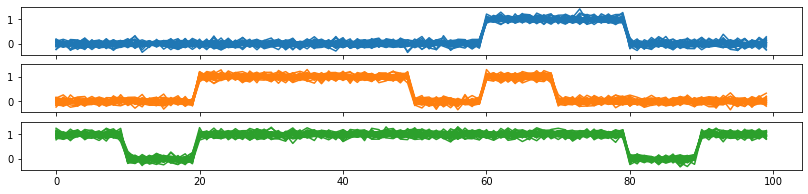

In [6]:
codes = [12,232,765]
samples = 30 #per type
list_of_series = make_binary_code_dataset(codes,samples,noise_factor=0.1)
plot_list_of_ts_over_subplots(list_of_series)

#### pynuTS clusterization

In [7]:
clts = DTWKmeans(num_clust = 3, num_iter = 5)
clts.fit(list_of_series)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:48<00:00,  9.71s/it]


#### New data generation

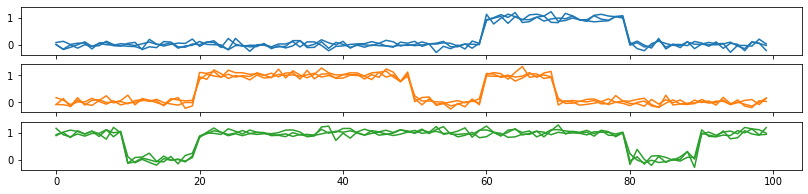

In [8]:
list_new = make_binary_code_dataset(codes,3,noise_factor=0.1)
plot_list_of_ts_over_subplots(list_new)

#### Clustering of new data

In [9]:
clustering_dict = clts.predict(list_new)
clustering_dict

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


{0: [3, 4, 5], 1: [0, 1, 2], 2: [6, 7, 8]}

#### Check results

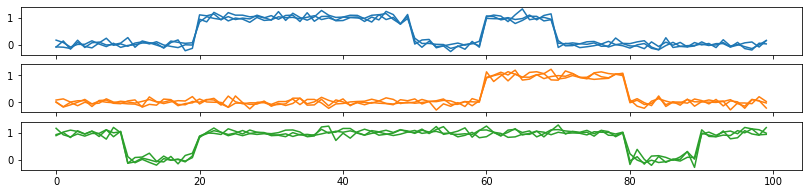

In [10]:
plot_list_of_ts_over_subplots(get_clustered_list(list_new,clustering_dict))

# Original Test 
This is the example dataset described in the DTWKmeans class in the original repo

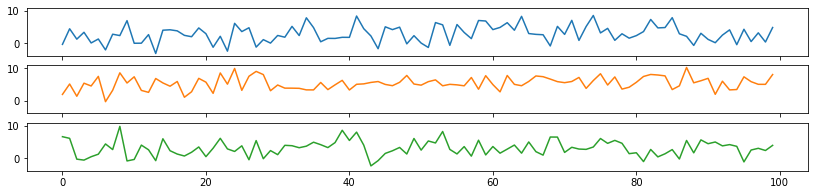

In [11]:
ts1 = 2.5 * np.random.randn(100,) + 3
X_1 = pd.Series(ts1,name=0)
ts2 = 2 * np.random.randn(100,) + 5
X_2 = pd.Series(ts2,name=1)
ts3 = -2.5 * np.random.randn(100,) +3
X_3 = pd.Series(ts3,name=2)
list_of_series = [X_1, X_2, X_3]

plot_list_of_ts_over_subplots(list_of_series)

In [12]:
clts = DTWKmeans(num_clust = 3, num_iter = 5)
clts.fit(list_of_series)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.64it/s]


In [13]:
ts4 = 3.5 * np.random.randn(100,) + 20
ts5 = -3.5 * np.random.randn(100,) - 20
X_4 = pd.Series(ts4)
X_5 = pd.Series(ts5)
list_new = [X_4, X_5]

In [14]:
clustering_dict = clts.predict(list_new)
clustering_dict

100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


{0: [], 1: [0], 2: [1]}

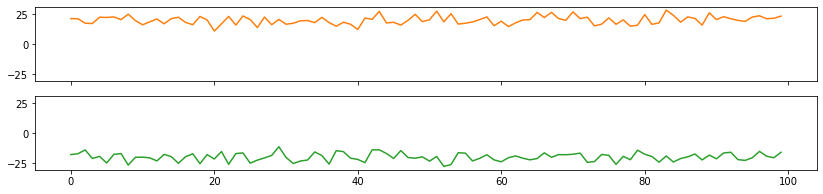

In [15]:
plot_list_of_ts_over_subplots(get_clustered_list(list_new,clustering_dict))